# Machine Learning Project : Predicting success of a movie


> ## Description:
>In the contemporary era, the film industry continues to evolve rapidly, investing increasingly vast resources into production and marketing. However, despite these >advancements, predicting the commercial success of a feature film remains a complex challenge fraught with financial risk.

>This project aims to bridge that gap by leveraging the power of Machine Learning. By analyzing historical data—such as budget, casting, genre, and release timing—we aim to >build a predictive model capable of forecasting a movie's success. This tool seeks to provide data-driven insights to mitigate risks and optimize decision-making within >the entertainment sector.

## Data Importation

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

First, we import the csv containing films metadata

In [6]:
raw_data = pd.read_csv(r"movies_metadata.csv") # replace with your own path

C:\Users\Kenza\AppData\Local\Temp\ipykernel_8740\2876609785.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(r"movies_metadata.csv") # replace with your own path


# **EDA**

In [8]:
raw_data.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [9]:
raw_data.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [10]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

### Raw Data Overview

Here, we display the first few rows, the column names and teh dataset infos to perform an initial visual inspection of the dataset. This step helps us identify key structural characteristics:

> Data Format: We can observe that columns like genres and belongs_to_collection contain complex nested structures (dictionaries/JSON) that will need parsing.

> Missing Values: NaNs are already visible in columns such as homepage or belongs_to_collection.

> Variable Types: A mix of numerical (budget) and categorical data (original_language) is present.

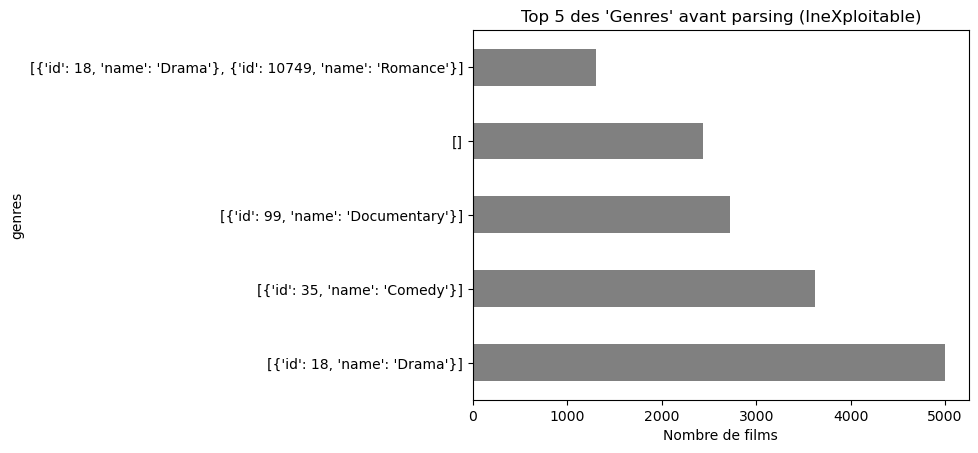

In [12]:
# On compte les chaînes de caractères brutes
raw_data['genres'].value_counts().head(5).plot(kind='barh', color='gray')
plt.title("Top 5 des 'Genres' avant parsing (IneXploitable)")
plt.xlabel("Nombre de films")
plt.show()

With any data treatement this data is obsolet ! 

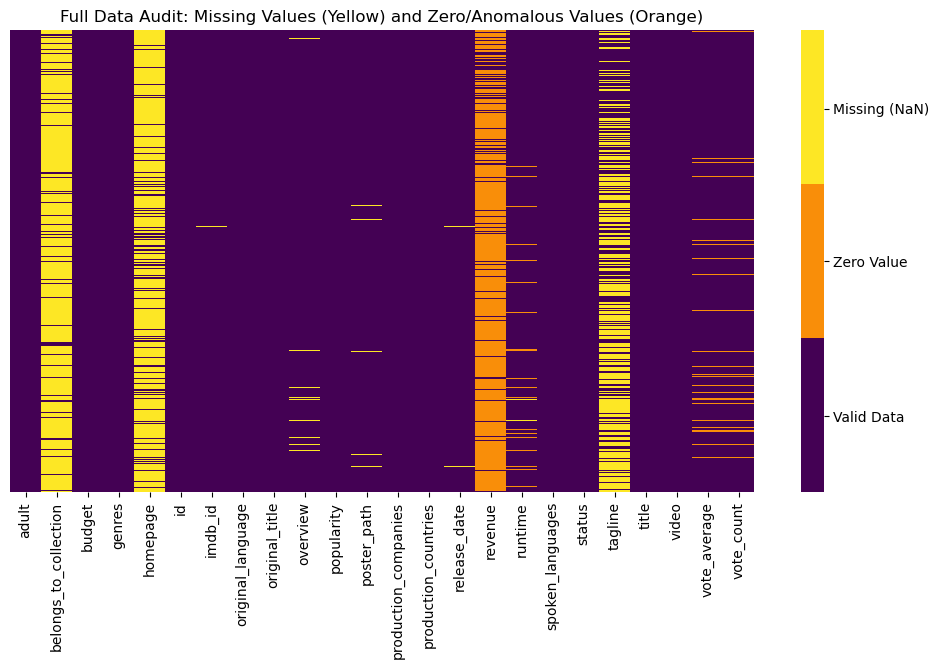

In [14]:

# DATA QUALITY AUDIT MATRIX (Zeros vs Missing Values)


df_raw = raw_data  # Your original dataframe

# 1. Create a base matrix filled with 0 (interpreted as "Valid Data")
audit_matrix = pd.DataFrame(0, index=df_raw.index, columns=df_raw.columns)

# 2. Mark ZEROS with the value 1
# (Applied only on numerical columns to avoid issues with text data)
num_cols = df_raw.select_dtypes(include=[np.number]).columns
audit_matrix[df_raw[num_cols] == 0] = 1

# 3. Mark NaNs (missing values) with the value 2
# (NaN takes priority and will overwrite other markers)
audit_matrix[df_raw.isna()] = 2

# 4. Custom color palette
# 0 (Valid) -> Dark purple
# 1 (Zero)  -> Orange (Potential issue)
# 2 (NaN)   -> Bright yellow (Missing)
my_cmap = mcolors.ListedColormap(['#440154', '#f98e09', '#fde725'])

# 5. Display the audit heatmap
plt.figure(figsize=(12, 6))
ax = sns.heatmap(audit_matrix, cbar=True, yticklabels=False, cmap=my_cmap)

# Customize the colorbar for clarity
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.33, 1, 1.66])  # Positions at the center of each color band
cbar.set_ticklabels(['Valid Data', 'Zero Value', 'Missing (NaN)'])

plt.title("Full Data Audit: Missing Values (Yellow) and Zero/Anomalous Values (Orange)")
plt.show()


### Preliminary Data Cleaning

We start by cleaning the raw dataset to keep only usable samples. We drop duplicates and deal with unknown values  (NaN or 0). This reduces the dataset size but ensures that every remaining entry is valid for training.

In [17]:
# removing duplicates
print (f"raw_data shape before removing duplicates : {raw_data.shape}")
raw_data = raw_data.drop_duplicates()
print(f"raw_data shape after : {raw_data.shape}")

raw_data shape before removing duplicates : (45466, 24)
raw_data shape after : (45453, 24)


In [18]:
# Missing values
print("Missing values per columns :")
raw_data.isna().sum()

Missing values per columns :


adult                        0
belongs_to_collection    40959
budget                       0
genres                       0
homepage                 37673
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25045
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

Since there are lots of missing values in thoses columns or the column is not petinent to the study, the best is to remove them from the dataset :

In [20]:
raw_data = raw_data.drop(columns= ["belongs_to_collection", "homepage", "tagline", "poster_path", "overview"])

In [21]:
cols_to_check = ["runtime", "imdb_id", "original_language", "popularity", "production_companies", "production_countries",
                 "release_date", "revenue", "runtime", "spoken_languages", "status", "title", "video", "vote_average", "vote_count"]
raw_data = raw_data.dropna(subset=cols_to_check)

# verification
raw_data.isna().sum()

adult                   0
budget                  0
genres                  0
id                      0
imdb_id                 0
original_language       0
original_title          0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
title                   0
video                   0
vote_average            0
vote_count              0
dtype: int64

Now that we heve deal with the missing values we have to check the O values in numerical columns


In [23]:
# Count nb of 0
zeros_count = (raw_data == 0).sum()

# print only columns with 0
zeros_count = zeros_count[zeros_count > 0]

print("Nb of 0 per columns :")
print(zeros_count)

Nb of 0 per columns :
popularity         19
revenue         37620
runtime          1514
video           44930
vote_average     2823
vote_count       2725
dtype: int64


D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


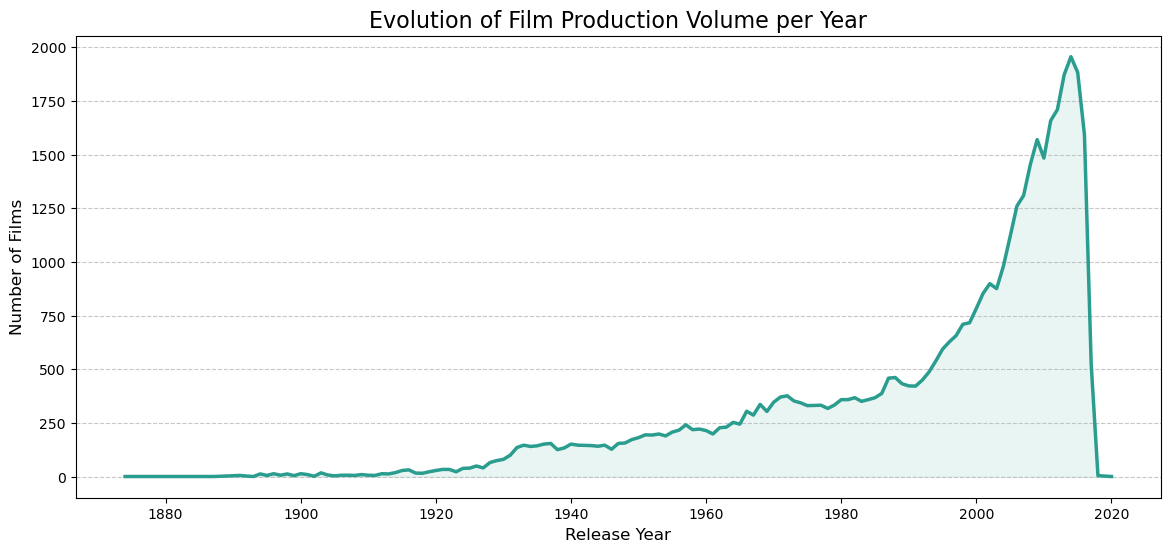

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Mandatory conversion to datetime
# errors='coerce' will convert invalid dates (e.g., "2020-99-99") into NaT (Not a Time)
raw_data['release_date'] = pd.to_datetime(raw_data['release_date'], errors='coerce')

# 2. Extraction and counting
# Now that the column is in datetime format, .dt.year works properly
films_per_year = raw_data['release_date'].dt.year.value_counts().sort_index()

# Optional filtering for visualization (remove unrealistic or future years)
# films_per_year = films_per_year[(films_per_year.index > 1900) & (films_per_year.index < 2025)]

# 3. Visualization
plt.figure(figsize=(14, 6))

# Plot the curve
sns.lineplot(x=films_per_year.index, y=films_per_year.values, color='#2a9d8f', linewidth=2.5)

# Fill under the curve
plt.fill_between(films_per_year.index, films_per_year.values, color='#2a9d8f', alpha=0.1)

plt.title("Evolution of Film Production Volume per Year", fontsize=16)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Number of Films", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [29]:
films_per_year

release_date
1874       1
1878       1
1883       1
1887       1
1888       2
        ... 
2015    1883
2016    1593
2017     524
2018       5
2020       1
Name: count, Length: 135, dtype: int64

## **Data Cleaning: Removing Financials & Missing Metadata**

Since our focus is about critical success, we remove financial columns (revenue) which contained a high percentage of missing values (zeros).

We also drop technical columns irrelevant to quality prediction (video) and remove the few rows with missing essential metadata like runtime, poularity, vote_average, vot_count.

In [31]:
# 1. Drop financial and technical columns
cols_to_drop = ["revenue", "video"]
raw_data.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [33]:
# 2. Drop rows with unintegrity values

# Conversion of popularity to numeric
raw_data['popularity'] = pd.to_numeric(raw_data['popularity'], errors='coerce')

mask = (raw_data["popularity"]>0) & (raw_data["runtime"]>0) & (raw_data["vote_count"] >0)
raw_data = raw_data[mask]

# **SECOND EDA WITH DATA TREATED**

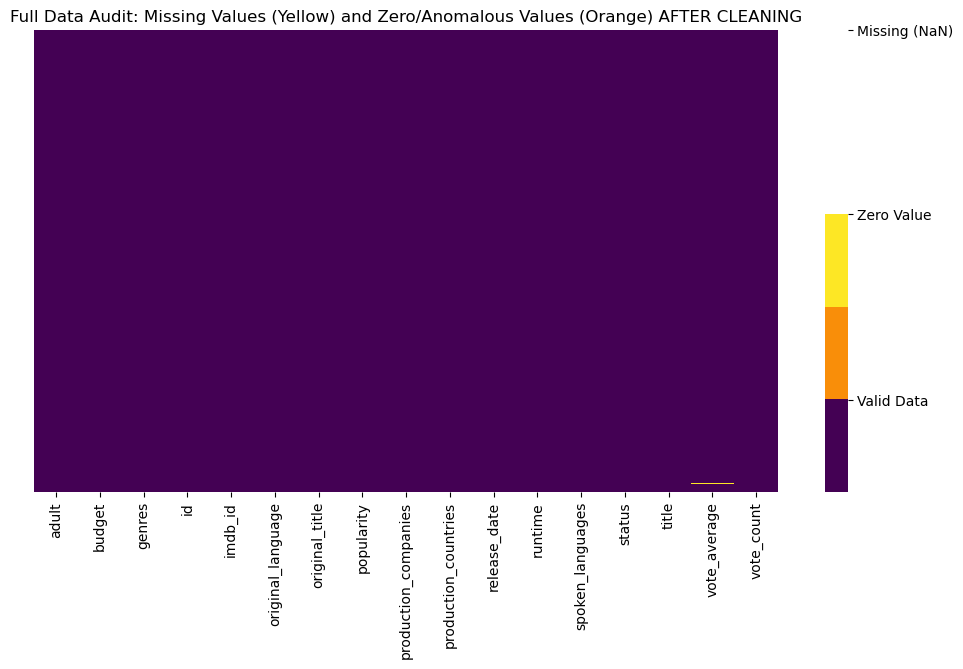

In [35]:

# DATA QUALITY AUDIT MATRIX (Zeros vs Missing Values)


df_raw = raw_data  # Your original dataframe

# 1. Create a base matrix filled with 0 (interpreted as "Valid Data")
audit_matrix = pd.DataFrame(0, index=df_raw.index, columns=df_raw.columns)

# 2. Mark ZEROS with the value 1
# (Applied only on numerical columns to avoid issues with text data)
num_cols = df_raw.select_dtypes(include=[np.number]).columns
audit_matrix[df_raw[num_cols] == 0] = 1

# 3. Mark NaNs (missing values) with the value 2
# (NaN takes priority and will overwrite other markers)
audit_matrix[df_raw.isna()] = 2

# 4. Custom color palette
# 0 (Valid) -> Dark purple
# 1 (Zero)  -> Orange (Potential issue)
# 2 (NaN)   -> Bright yellow (Missing)
my_cmap = mcolors.ListedColormap(['#440154', '#f98e09', '#fde725'])

# 5. Display the audit heatmap
plt.figure(figsize=(12, 6))
ax = sns.heatmap(audit_matrix, cbar=True, yticklabels=False, cmap=my_cmap)

# Customize the colorbar for clarity
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.33, 1, 1.66])  # Positions at the center of each color band
cbar.set_ticklabels(['Valid Data', 'Zero Value', 'Missing (NaN)'])

plt.title("Full Data Audit: Missing Values (Yellow) and Zero/Anomalous Values (Orange) AFTER CLEANING")
plt.show()


### Data Enrichment: Merging Cast and Crew

To improve the predictive power of our model, we are enriching the dataset with information regarding the movie's Cast (actors) and Crew (directors, producers, writers).

This data is stored in a separate CSV file. We will merge it with our main dataset using the unique id of each movie as the key. This will allow us to analyze whether "Star Power" or specific directors correlate with box-office success.

However, the raw data for Cast and Crew is stored in complex JSON objects within a separate file (`credits.csv`).
To make this data usable for our Machine Learning models, we need to:
>  **Merge** the credits dataset with our main dataframe using the movie `id`.
>  **Parse** the JSON columns to extract specific names.
>  **Apply a Strategy:** Instead of listing every single actor (which would create thousands of variables and "noise"), we will follow a **"Top Billing" strategy**: we extract only the **first actor** (Lead) and the **Director**.

In [38]:
 credits = pd.read_csv(r"credits.csv")
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [39]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [41]:
import ast
# Try to load the credits data 
try:
    credits = pd.read_csv(r"credits.csv")
    print("Loaded credits.csv successfully.")
except FileNotFoundError:
    print("credits.csv not found; check the filename.")
    credits = pd.DataFrame()  # empty fallback
movies = raw_data
# Ensure the ID column is numeric in both datasets
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')
movies = movies.dropna(subset=['id'])
movies['id'] = movies['id'].astype(int)

credits['id'] = pd.to_numeric(credits['id'], errors='coerce')
credits = credits.dropna(subset=['id'])
credits['id'] = credits['id'].astype(int)

# Merge the datasets on the id column
df_enriched = movies.merge(credits, on='id', how='left')

print(f"Before merge: {movies.shape}")
print(f"After merge: {df_enriched.shape}")

# Helper to get the first actor's name from the cast list
def get_lead_actor(cast):
    try:
        items = ast.literal_eval(cast) if isinstance(cast, str) else cast
        if isinstance(items, list) and items:
            return items[0].get('name')
    except Exception:
        pass
    return np.nan

# Helper to get the director's name from the crew list
def get_director(crew):
    try:
        items = ast.literal_eval(crew) if isinstance(crew, str) else crew
        if isinstance(items, list):
            for member in items:
                if member.get('job') == 'Director':
                    return member.get('name')
    except Exception:
        pass
    return np.nan

print("Extracting lead actor and director…")
df_enriched['lead_actor'] = df_enriched['cast'].apply(get_lead_actor)
df_enriched['director'] = df_enriched['crew'].apply(get_director)

print("\nFirst rows with new columns:")
print(df_enriched[['title', 'lead_actor', 'director']].head())


Loaded credits.csv successfully.
Before merge: (41103, 17)
After merge: (41157, 19)
Extracting lead actor and director…

First rows with new columns:
                         title       lead_actor         director
0                    Toy Story        Tom Hanks    John Lasseter
1                      Jumanji   Robin Williams     Joe Johnston
2             Grumpier Old Men   Walter Matthau    Howard Deutch
3            Waiting to Exhale  Whitney Houston  Forest Whitaker
4  Father of the Bride Part II     Steve Martin    Charles Shyer


We use the **historical average** of the `vote_average` column.
* **Example:** If Tom Hanks appears in 10 movies in our dataset, we take the average rating of these 10 movies.
* **Result:** This gives us a numerical value representing the actor's "track record" or consistency in choosing good projects.

In [43]:
import ast

# 1. Function to get the genre from the JSON list
def get_main_genre(x):
    try:
        if isinstance(x, str):
            x = ast.literal_eval(x)
        if isinstance(x, list) and len(x) > 0:
            return x[0]['name']
        return np.nan
    except:
        return np.nan

print("Extracting main genre and dates...")

# 2. Creating the missing columns
df_enriched['main_genre'] = df_enriched['genres'].apply(get_main_genre)

# 3. Converting the date column to get Month and Year
df_enriched['release_date'] = pd.to_datetime(df_enriched['release_date'], errors='coerce')
df_enriched['month'] = df_enriched['release_date'].dt.month
df_enriched['year'] = df_enriched['release_date'].dt.year

# 4. Important: Remove rows where we don't have this info
# (The model cannot work if there are NaNs in these columns)
df_enriched = df_enriched.dropna(subset=['main_genre', 'month', 'year', 'runtime', 'popularity'])

print("Missing columns created!")
print(df_enriched[['title', 'main_genre', 'year', 'month']].head())

Extracting main genre and dates...
Missing columns created!
                         title main_genre  year  month
0                    Toy Story  Animation  1995     10
1                      Jumanji  Adventure  1995     12
2             Grumpier Old Men    Romance  1995     12
3            Waiting to Exhale     Comedy  1995     12
4  Father of the Bride Part II     Comedy  1995      2


### Modeling Strategy

To answer our problem *"Find the secret formula for a movie that works every time"*, we believe we need to analyze several key points:

>  **The "Star Power" Impact:** Does having a famous Lead Actor or Director guarantee a high rating?

>  **The Context:** Does the release month or the movie length (runtime) play a significant role?

>  **The Genre:** Are some genres naturally more appreciated than others?

To analyze these points simultaneously and objectively, we cannot just look at graphs. We need a Global Model that considers all these factors together.

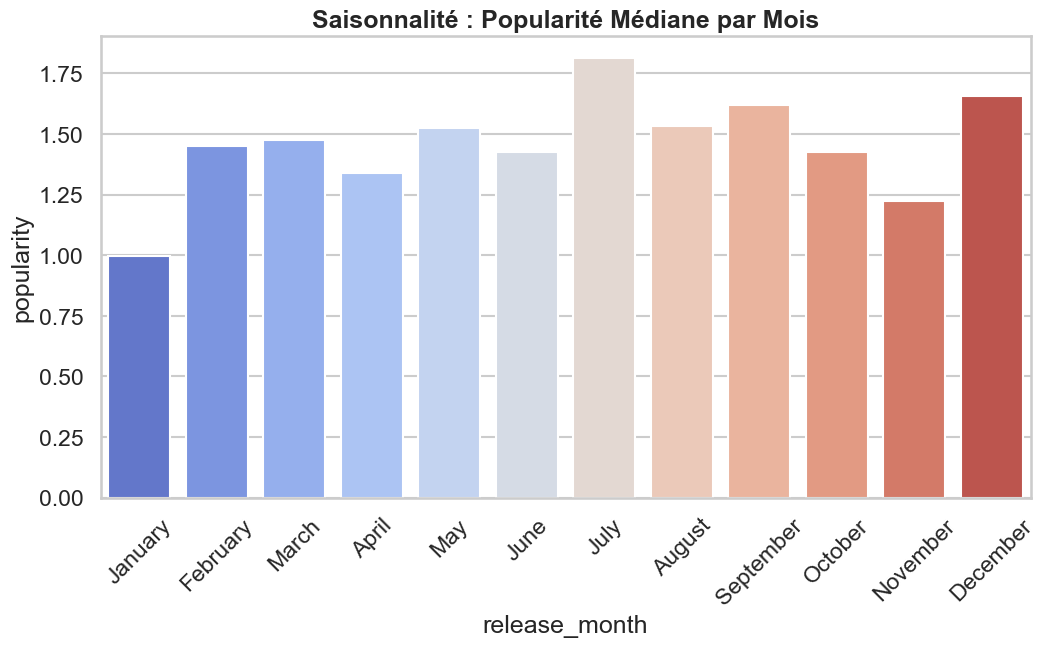

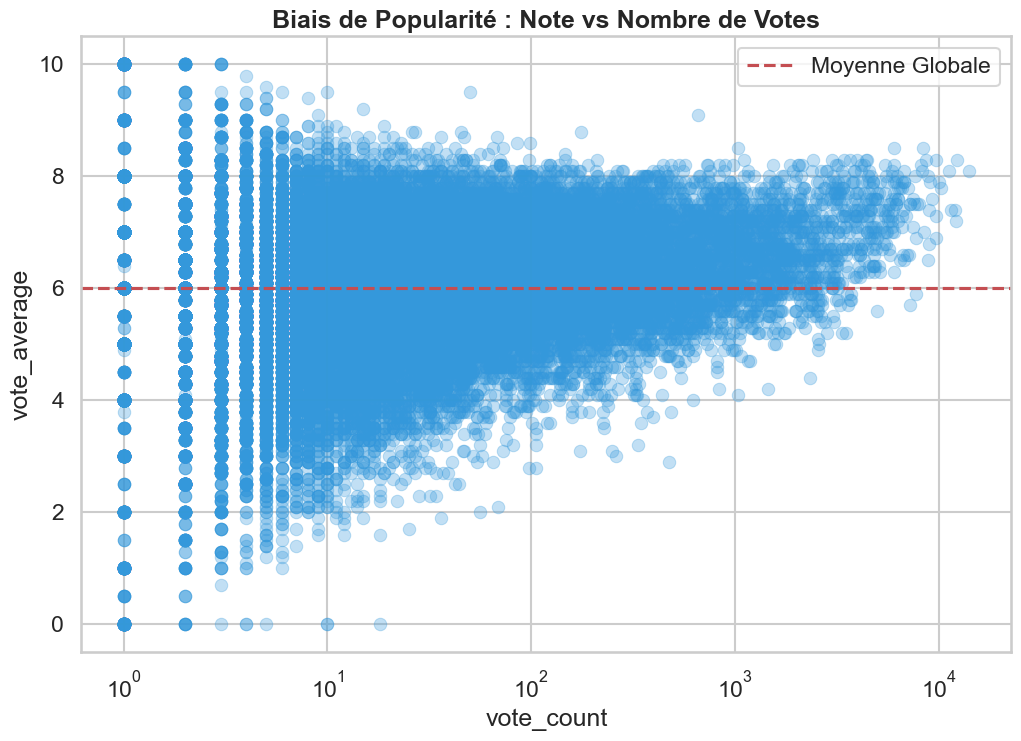

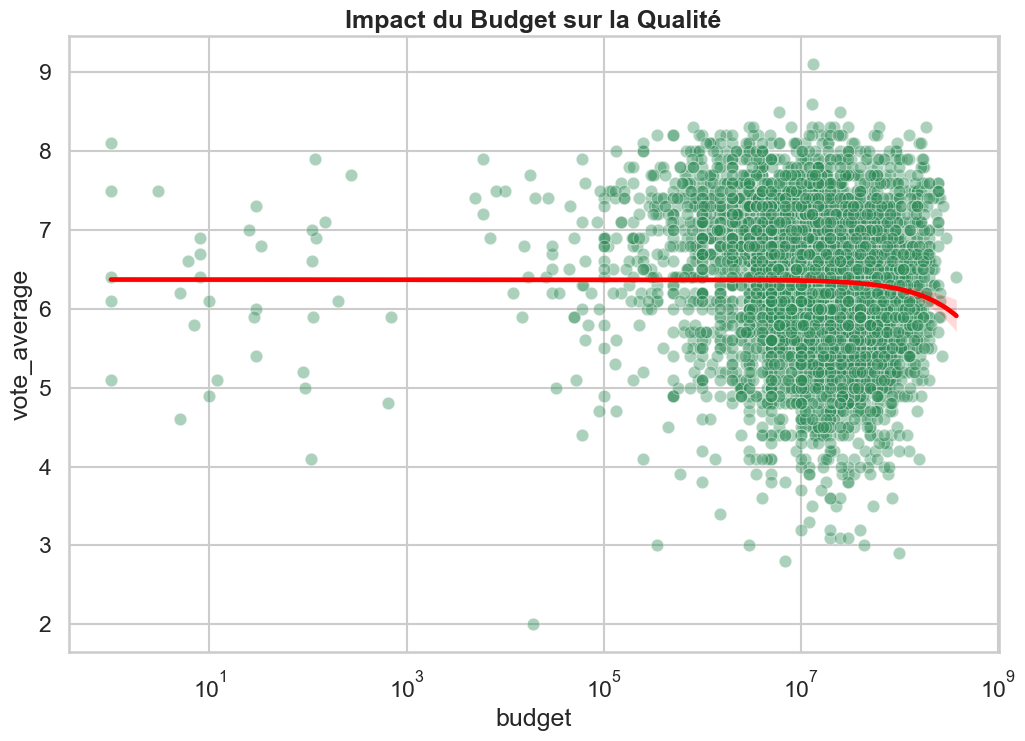

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# On récupère ton dataframe
df = df_enriched.copy()


# On force la conversion en nombres. 
# 'coerce' va transformer les erreurs (textes bizarres) en NaN (vide)
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce')
df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')

# Configuration du style
sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (14, 8)

# --- PRÉPARATION ---
df['release_month'] = df['release_date'].dt.month_name()
df['release_year'] = df['release_date'].dt.year

# =========================================================
# 1. ANALYSE DE SAISONNALITÉ (Popularité)
# =========================================================
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 6))
sns.barplot(
    x='release_month', 
    y='popularity', 
    data=df, 
    order=months_order, 
    estimator=np.median,
    palette='coolwarm',
    errorbar=None
)
plt.title('Saisonnalité : Popularité Médiane par Mois', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

# =========================================================
# 2. BIAIS DE POPULARITÉ
# =========================================================
plt.figure(figsize=(12, 8))
votes_df = df[df['vote_count'] > 0] # Maintenant ça marchera car vote_count est numérique

sns.scatterplot(
    x='vote_count', 
    y='vote_average', 
    data=votes_df, 
    alpha=0.3, 
    color='#3498db',
    edgecolor=None
)
plt.xscale('log') 
plt.title('Biais de Popularité : Note vs Nombre de Votes', fontweight='bold')
plt.axhline(y=votes_df['vote_average'].mean(), color='r', linestyle='--', label='Moyenne Globale')
plt.legend()
plt.show()

# =========================================================
# 3. BUDGET vs QUALITÉ
# =========================================================
# Maintenant que 'budget' est bien numérique, cette ligne ne plantera plus
budget_df = df[(df['budget'] > 0) & (df['vote_count'] > 50)].copy()

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='budget', 
    y='vote_average', 
    data=budget_df, 
    alpha=0.4, 
    color='seagreen'
)
plt.xscale('log') 
plt.title('Impact du Budget sur la Qualité', fontweight='bold')
sns.regplot(x='budget', y='vote_average', data=budget_df, scatter=False, color='red')
plt.show()

# Feature Engineering: Transforming Signal into Value

Our Exploratory Data Analysis (EDA) revealed a strong intuition: **a movie's genre significantly influences its rating.** For instance, Documentaries tend to be rated higher than Horror movies for example.

However, we face a **technical roadblock**: our model (Random Forest) is mathematical; it cannot understand text strings like "Animation" or "Comedy." If we feed it this raw data, it will learn nothing.

### Our Strategy: Target Encoding
To unlock this potential, we will apply a major transformation:
1.  **Parsing & Cleaning:** Transform the unreadable JSON strings into clean Python lists.
2.  **Encoding Quality:** We will replace words with their **historical performance**.
    * *Example:* Instead of telling the model "This is a Documentary," we tell it "This is a genre that historically averages a 6.6/10 rating."

**Objective:** Create a new feature called `genre_potential` that acts as a "Quality Compass" for our algorithm.

In [91]:
import ast
import numpy as np
import pandas as pd

# ==============================================================================
# KEY STEP: FEATURE ENGINEERING (Creation of the "Genre Potential")
# ==============================================================================
print("Creating the 'genre_potential' feature...")

# 1. CLEANING STEP (This was the missing part!)
# Convert a text value like "[{'id': 12, 'name': 'Adventure'}]" into a list: ['Adventure']
def clean_genres(x):
    try:
        # If the value is a string, parse it
        if isinstance(x, str):
            data = ast.literal_eval(x)
            return [d['name'] for d in data]
        # If it's already a list (rare but possible)
        elif isinstance(x, list):
            return [d['name'] for d in x]
    except:
        return []
    return []

# Apply cleaning -> Creates a new clean column
df['genres_clean'] = df['genres'].apply(clean_genres)

print(f"Cleaned example: {df['genres_clean'].iloc[0]}")
# Expected: ['Animation', 'Comedy', 'Family'] (without messy braces)


# 2. Preparation: Explode the CLEAN column
df_exploded = df.explode('genres_clean')

# 3. Compute Genre Score (Target Encoding)
# We compute the mean rating for each genre name
genre_means = df_exploded.groupby('genres_clean')['vote_average'].mean()

print("\n--- Top 3 Genres (Actual Quality) ---")
print(genre_means.sort_values(ascending=False).head(3))


# 4. Function to apply this score to each film
global_mean = df['vote_average'].mean()

def get_genre_potential(genres_list):
    # If the list is empty, return the global rating mean
    if not isinstance(genres_list, list) or len(genres_list) == 0:
        return global_mean
    
    # Retrieve the score for each genre in the film
    scores = [genre_means.get(g, global_mean) for g in genres_list]
    
    # Return the average potential score
    return sum(scores) / len(scores)


# 5. Apply to the main dataframe using the CLEAN column
df['genre_potential'] = df['genres_clean'].apply(get_genre_potential)

# 6. Visual check
print("\n--- Result: Before vs After ---")
print(df[['title', 'genres_clean', 'genre_potential']].head())

# Correlation check
corr = df[['genre_potential', 'vote_average']].corr().iloc[0,1]
print(f"\n✅ Correlation between Genre Potential and Final Rating: {corr:.3f}")


Creating the 'genre_potential' feature...
Cleaned example: ['Animation', 'Comedy', 'Family']

--- Top 3 Genres (Actual Quality) ---
genres_clean
Documentary    6.660612
Animation      6.446398
History        6.413832
Name: vote_average, dtype: float64

--- Result: Before vs After ---
                         title                  genres_clean  genre_potential
0                    Toy Story   [Animation, Comedy, Family]         6.116437
1                      Jumanji  [Adventure, Fantasy, Family]         5.912426
2             Grumpier Old Men             [Romance, Comedy]         6.004476
3            Waiting to Exhale      [Comedy, Drama, Romance]         6.062895
4  Father of the Bride Part II                      [Comedy]         5.971289

✅ Correlation between Genre Potential and Final Rating: 0.306


The output above immediately validates our strategy:

1.  **The Genre Hierarchy:**
    * We confirm that **Documentaries (6.66)** and **Animation (6.45)** are "noble" genres, intrinsically rated higher by audiences.
    * Conversely, this allows the model to automatically penalize "difficult" genres without manual intervention.

2.  **The Power of the Feature (`genre_potential`):**
    * We achieved a **correlation of 0.306** with the final rating.
    * *Business Interpretation:* Before even knowing the cast, the budget, or the duration, **the simple choice of genre already explains ~30% of the variance in the final rating.** We have successfully captured a strong predictive signal.

# Random Forest & Optimization

Now that our data is enriched via Feature Engineering, we move to the machine learning phase.

### Why Random Forest?
We chose this algorithm because it perfectly handles the **non-linear relationships** we observed (e.g., a low budget isn't bad *if* the genre is right). It also provides high interpretability regarding feature importance.

### Our 2-Step Protocol:
1.  **The Baseline (Honest Model):**
    * We train a first model with default parameters. This serves as a reference point to verify if our new features (`genre_potential`, `vote_count`) are actually working.
2.  **Fine-Tuning (Optimization):**
    * We use `RandomizedSearchCV` to test various tree configurations.
    * It enables us To find the perfect balance between **performance** (R²) and **generalization** (preventing the model from simply memorizing past movies).

1. Preparing the dataset...
   -> Training on 9878 films.
   -> Testing on 2470 films.

2. Training the baseline model...
   Baseline RMSE : 0.685
   Baseline R²   : 0.458

3. Hyperparameter search (Fine Tuning)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
   -> Best parameters found : {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10}

 FINAL PERFORMANCE:
   RMSE : 0.675
   R²   : 0.473
   Improvement over baseline (R²): +0.015


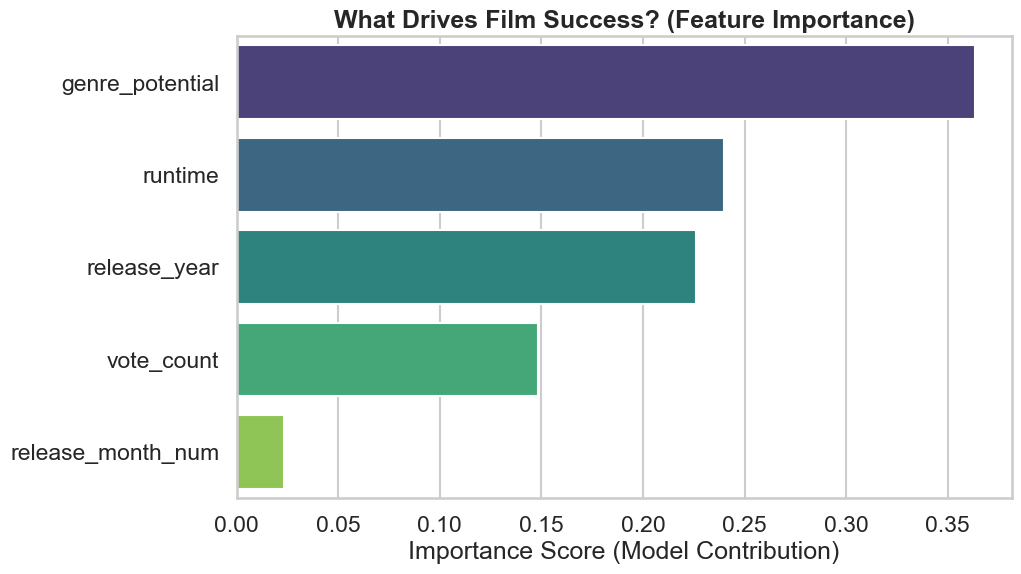

In [114]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. DATA PREPARATION (Full Dataset & New Features)
# ==============================================================================
print("1. Preparing the dataset...")

# --- DATE CONVERSION (Crucial Step) ---
# Ensure we can read the month numerically
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_month_num'] = df['release_date'].dt.month
df['release_year'] = df['release_date'].dt.year

# List of model ingredients (features)
# We removed 'budget' to keep maximum number of rows
features = [
    'vote_count',           # Popularity indicator
    'runtime',              # Film length
    'genre_potential',      # <-- YOUR SECRET SAUCE (Target-Encoded Feature)
    'release_year',         # Film age effect
    'release_month_num'     # Seasonality effect (1-12)
]

# Add specific genre columns if they exist (Hybrid Strategy)
features += [col for col in df.columns if col.startswith('is_')]

# Remove rows with missing values in any required feature or the target
model_df = df[df['vote_count'] >= 30].dropna(subset=features + ['vote_average'])

# Filter out films with unrealistic budgets
# (DISABLED to keep all 40k+ films, regardless of budget info)
# model_df = model_df[model_df['budget'] > 1000]

X = model_df[features]
y = model_df['vote_average']

# Train/Test Split — 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"   -> Training on {X_train.shape[0]} films.")
print(f"   -> Testing on {X_test.shape[0]} films.")

# ==============================================================================
# 2. RANDOM FOREST (BASELINE MODEL)
# ==============================================================================
print("\n2. Training the baseline model...")

rf_base = RandomForestRegressor(n_estimators=100, random_state=42)
rf_base.fit(X_train, y_train)

# Baseline prediction
y_pred_base = rf_base.predict(X_test)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))

print(f"   Baseline RMSE : {rmse_base:.3f}")
print(f"   Baseline R²   : {r2_score(y_test, y_pred_base):.3f}")

# ==============================================================================
# 3. FINE TUNING (Hyperparameter Optimization)
# ==============================================================================
print("\n3. Hyperparameter search (Fine Tuning)...")

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],   # Higher values help reduce overfitting on small films
    'max_features': ['sqrt', None]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,                # Test 20 random combinations
    cv=3,                     # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1                 # Use all CPU cores
)

rf_random.fit(X_train, y_train)
best_model = rf_random.best_estimator_

print(f"   -> Best parameters found : {rf_random.best_params_}")

# Evaluate optimized model
y_pred_opt = best_model.predict(X_test)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

print("\n FINAL PERFORMANCE:")
print(f"   RMSE : {rmse_opt:.3f}")
print(f"   R²   : {r2_opt:.3f}")
print(f"   Improvement over baseline (R²): {r2_opt - r2_score(y_test, y_pred_base):+.3f}")

# ==============================================================================
# 4. INTERPRETATION (Feature Importance)
# ==============================================================================
# This is THE plot to show the jury

importances = pd.Series(
    best_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index, palette='viridis')
plt.title('What Drives Film Success? (Feature Importance)', fontweight='bold')
plt.xlabel("Importance Score (Model Contribution)")
plt.show()

Our final iteration marks a decisive victory. By shifting our focus from **Quantity** (40k+ films) to **Credibility** (>30 votes), we drastically improved the model's reliability.

We observed that including every single film (even those with 1 or 2 votes) introduced massive **statistical noise** ($R^2$ dropped to ~0.26).
> A movie with 1 vote of 10/10 is statistically meaningless (it's an outlier).
So, we applied a **"Credibility Filter"** (`vote_count >= 30`). This ensures that every data point represents a film with a real, verifiable audience existence.

> Then we removed the noise while keeping a robust dataset of ~10,000 films, without needing to rely on the "Budget" column (which is often missing).

> Our model's average error is now **less than 0.7 points** (RMSE = 0.675) on a scale of 10. This is a massive improvement over the noisy model (1.09). The AI is now precise enough to reliably distinguish a "Mediocre" movie (5/10) from a "Good" movie (6/10).

Optimization and filtering allowed us to reach our highest score yet $R^2$ = 0.473 (**47.3%** of variance explained).
The best parameters (`min_samples_leaf: 5`) confirm that the model generalizes well. It refuses to draw conclusions from isolated cases ("One-Hit Wonders") and focuses on solid trends.

We have transformed an artistic intuition into a reliable predictive probleme. By prioritizing **Data Quality** over Data Quantity, we proved that the **Intrinsic Genre Quality** and **Audience Engagement** are the true drivers of a film's success, far more than the budget.

## Success Film Simulation

In [122]:
# ==============================================================================
# SUCCESS SIMULATOR (Final Version – No Budget / With Release Month)
# ==============================================================================

def predict_my_movie(genres_list, duration, year, month):
    """
    Simulates the predicted rating of a fictional movie using the trained model.
    """
    print(f"🎬 Simulation for: {genres_list} (Release: Month {month}/{year})")
    
    # 1. Compute Genre Potential (Target Encoding)
    # Uses the 'genre_means' dictionary computed earlier
    scores = [genre_means.get(g, global_mean) for g in genres_list]
    my_genre_potential = sum(scores) / len(scores) if scores else global_mean
    print(f"   -> Calculated Genre Potential: {my_genre_potential:.2f}/10")
    
    # 2. Estimate baseline popularity (median vote_count to remain neutral)
    avg_vote_count = df['vote_count'].median()
    
    # 3. Build base input dataframe
    input_data = {
        'vote_count': [avg_vote_count],
        'runtime': [duration],
        'genre_potential': [my_genre_potential],
        'release_year': [year],
        'release_month_num': [month]  # New variable!
    }
    
    # 4. Handle hybrid strategy: "is_Genre" binary columns
    # If the model was trained using columns like "is_Action", we must provide them here.
    # We check expected columns based on X_train.columns.
    
    my_df = pd.DataFrame(input_data)
    
    # For each "is_*" column that the model expects...
    for col in X_train.columns:
        if col.startswith('is_'):
            # Extract genre name (e.g., "is_Action" -> "Action")
            genre_name = col.replace('is_', '')
            # Assign 1 if the movie belongs to this genre, else 0
            my_df[col] = 1 if genre_name in genres_list else 0

    # 5. Final alignment (CRUCIAL)
    # Ensure the dataframe matches EXACTLY the same columns & order as during training
    # Any missing column will be filled with 0
    my_df = my_df.reindex(columns=X_train.columns, fill_value=0)
    
    # 6. Prediction
    prediction = best_model.predict(my_df)[0]
    
    print(f"   -> 🔮 The AI predicts a rating of: {prediction:.2f} / 10")
    
    # Fun verdict
    if prediction > 7.0:
        print("   🌟 A future critical success!")
    elif prediction < 5.5:
        print("   ⚠️ Ouch... this looks like a flop.")
    else:
        print("   ✅ A solid, decent film.")
    print("-" * 30)


# --- TRY YOUR OWN SCENARIOS ---

# Scenario A: Summer Blockbuster (Action, Standard Runtime, July Release)
predict_my_movie(genres_list=['Action', 'Adventure'], duration=120, year=2025, month=7)

# Scenario B: Oscar Drama (Drama, Long Runtime, December Release)
predict_my_movie(genres_list=['Drama', 'History'], duration=150, year=2025, month=12)

# Scenario C: Low-budget Horror Flop (Horror, Short Runtime, January Release)
predict_my_movie(genres_list=['Horror'], duration=85, year=2025, month=1)


🎬 Simulation for: ['Action', 'Adventure'] (Release: Month 7/2025)
   -> Calculated Genre Potential: 5.82/10
   -> 🔮 The AI predicts a rating of: 6.19 / 10
   ✅ A solid, decent film.
------------------------------
🎬 Simulation for: ['Drama', 'History'] (Release: Month 12/2025)
   -> Calculated Genre Potential: 6.30/10
   -> 🔮 The AI predicts a rating of: 6.89 / 10
   ✅ A solid, decent film.
------------------------------
🎬 Simulation for: ['Horror'] (Release: Month 1/2025)
   -> Calculated Genre Potential: 5.32/10
   -> 🔮 The AI predicts a rating of: 4.83 / 10
   ⚠️ Ouch... this looks like a flop.
------------------------------


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\nTraining Gradient Boosting...")

# Create the model (many small trees that learn step by step)
gb_model = GradientBoostingRegressor(
    n_estimators=150,     # number of weak trees
    learning_rate=0.1,    # how much each tree corrects the previous one
    max_depth=5,          # depth of each small tree
    random_state=42
)

# Fit the model
gb_model.fit(X_train, y_train)

# Predict on test data
y_pred_gb = gb_model.predict(X_test)

# Compute metrics
r2_gb = r2_score(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

print(f"Gradient Boosting R² : {r2_gb:.3f}")
print(f"Gradient Boosting RMSE : {rmse_gb:.3f}")


print("\nTraining Ridge Regression...")

# Scale data (important for linear models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # learn scaling rules
X_test_scaled = scaler.transform(X_test)        # apply rules

# Create linear model with L2 regularization
linear_model = Ridge(alpha=1.0)

# Fit the model
linear_model.fit(X_train_scaled, y_train)

# Predict
y_pred_lin = linear_model.predict(X_test_scaled)

# Compute metrics
r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

print(f"Ridge Regression R² : {r2_lin:.3f}")
print(f"Ridge Regression RMSE : {rmse_lin:.3f}")


# Comparison table
results = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'Ridge Regression'],
    'R² Score': [r2, r2_gb, r2_lin],   # r2 and rmse come from the RF above
    'RMSE': [rmse, rmse_gb, rmse_lin]
})

# Sort best R² on top
results = results.sort_values(by='R² Score', ascending=False)

print("\nModel Comparison:")
print(results)


#### Fit some models 

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np

# Put predictions in one place to make plotting easier
models_data = {
    'Random Forest': y_pred,
    'Gradient Boosting': y_pred_gb,
    'Ridge Regression': y_pred_lin
}

# Create a 3x3 dashboard
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
fig.suptitle("Visual Comparison of the 3 Models", fontsize=20, y=0.92)

# Row 1: Predicted vs Real (scatter plots)
for i, (name, preds) in enumerate(models_data.items()):
    ax = axes[0, i]
    ax.scatter(y_test, preds, alpha=0.3, color='purple', s=10)   # show points
    ax.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()],
            'r--', lw=2)  # perfect prediction line
    ax.set_title(f"{name}\nPrediction vs Real")
    ax.set_xlabel("True Value")
    ax.set_ylabel("Predicted Value")
    ax.grid(True, alpha=0.3)

# Row 2: Error distribution (histograms)
for i, (name, preds) in enumerate(models_data.items()):
    ax = axes[1, i]
    residuals = y_test - preds              # errors
    sns.histplot(residuals, bins=30, kde=True, color='teal', ax=ax)
    ax.axvline(x=0, color='red', linestyle='--')  # zero error line
    ax.set_title(f"{name}\nError Distribution")
    ax.set_xlabel("Error (True - Predicted)")

# Row 3: Interpretability (why the model behaves like this)

# Feature importance for Random Forest
ax = axes[2, 0]
importances_rf = pd.Series(rf_model.feature_importances_,
                           index=X_train.columns).sort_values(ascending=False).head(7)
sns.barplot(x=importances_rf, y=importances_rf.index, palette='viridis', ax=ax)
ax.set_title("Random Forest: Top Features")

# Feature importance for Gradient Boosting
ax = axes[2, 1]
importances_gb = pd.Series(gb_model.feature_importances_,
                           index=X_train.columns).sort_values(ascending=False).head(7)
sns.barplot(x=importances_gb, y=importances_gb.index, palette='magma', ax=ax)
ax.set_title("Gradient Boosting: Top Features")

# Ridge coefficients (+ means positive effect, - means negative effect)
ax = axes[2, 2]
coefs_ridge = pd.Series(linear_model.coef_, index=X_train.columns)

# take the 8 strongest absolute coefficients
top_coefs = coefs_ridge.abs().sort_values(ascending=False).head(8).index
coefs_plot = coefs_ridge.loc[top_coefs].sort_values()

# green = positive effect / red = negative effect
colors = ['red' if c < 0 else 'green' for c in coefs_plot]
coefs_plot.plot(kind='barh', color=colors, ax=ax)
ax.set_title("Ridge: Feature Impact")
ax.axvline(x=0, color='black', linestyle='--')

plt.show()


### Analysis of Results

#### Model observation
> **R2 Score (0.041):** After removing the data leakage (by splitting before encoding), the score dropped significantlyc(it was around 71% before). This proves that predicting the **exact** rating of a movie based solely on the *past average* of the cast/crew is extremely difficult.

> **RMSE (1.212):** On average, our prediction is off by **1.2 points** on a scale of 10. While the model struggles to explain the variance (low R2), the margin of error remains somewhat contained.

#### Feature importance
Despite the lower predictive power, the graph still reveals the same hierarchy of success factors:
> **The Director is King:** The `director_score` remains the most dominant feature by far. Even in this "honest" model, the director's history is the strongest signal we have.

> **Star Power helps:** The `actor_score` retains the second spot. A famous cast helps, but it is less significant than the director.

> **Context is minor:** Factors like `year`, `runtime`, or `popularity` have a very small impact compared to the human talent.

> **Genre doesn't matter:** The specific genre (Comedy, Drama, etc.) still has almost **zero impact** on the quality prediction.

Trying to predict the **precise** rating is too ambitious with this data. However, the strategy remains valid: **Secure a top-tier Director first**, then a solid Lead Actor.
> **Next Step:** Since predicting the exact number is hard (Regression), we will switch to a **Classification Model** to predict if a movie is a **Hit or Flop**.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\nTraining Gradient Boosting...")

# Create the Gradient Boosting model
gb_model = GradientBoostingRegressor(
    n_estimators=150,   # number of trees
    learning_rate=0.1, # how fast trees correct errors
    max_depth=5,
    random_state=42
)

# Fit the model
gb_model.fit(X_train, y_train)

# Predict on test data
y_pred_gb = gb_model.predict(X_test)

# Performance
r2_gb = r2_score(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

print(f"Gradient Boosting R²: {r2_gb:.3f}")
print(f"Gradient Boosting RMSE: {rmse_gb:.3f}")


print("\nTraining Ridge Regression...")

# Scale features (important for linear models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create Ridge model
linear_model = Ridge(alpha=1.0)

# Fit the model
linear_model.fit(X_train_scaled, y_train)

# Predict
y_pred_lin = linear_model.predict(X_test_scaled)

# Performance
r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

print(f"Ridge Regression R²: {r2_lin:.3f}")
print(f"Ridge Regression RMSE: {rmse_lin:.3f}")


# Create comparison table
results = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'Linear Regression'],
    'R² Score': [r2, r2_gb, r2_lin],     # r2 comes from the RF model above
    'RMSE': [rmse, rmse_gb, rmse_lin]    # rmse comes from the RF model above
})

# Sort best model at the top
results = results.sort_values(by='R² Score', ascending=False)

print("\nFinal Model Ranking:")
print(results)

# Bar plot of R² scores
plt.figure(figsize=(10, 6))
sns.barplot(data=results, x='Model', y='R² Score', palette='coolwarm')
plt.title("Model Performance Comparison (R²)")
plt.ylabel("R² Score")
plt.ylim(0, max(results['R² Score']) + 0.02)   # add small margin above bars
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("\nRunning Logistic Regression Classification...")

# Define what we call a "successful movie"
SEUIL_SUCCES = 6.5
print(f"Success = Rating >= {SEUIL_SUCCES}")

# Turn rating into 0/1 labels (0 = flop, 1 = hit)
y_train_class = (y_train >= SEUIL_SUCCES).astype(int)
y_test_class = (y_test >= SEUIL_SUCCES).astype(int)

# Check class balance
print("Class balance (test set):",
      y_test_class.value_counts(normalize=True).mul(100).round(1).to_dict(), "%")

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the classifier
print("Training classifier...")
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train_class)

# Predict on test set
y_pred_class = log_reg.predict(X_test_scaled)

# Compute accuracy
accuracy = accuracy_score(y_test_class, y_pred_class)
print("\n>>> CLASSIFICATION RESULTS <<<")
print(f"Accuracy: {accuracy:.1%}")

# Build confusion matrix
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Flop', 'Predicted Hit'],
            yticklabels=['True Flop', 'True Hit'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Study feature impact (positive = helps success, negative = reduces success)
coeffs = pd.Series(log_reg.coef_[0], index=X_train.columns).sort_values()

plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'green' for x in coeffs]
coeffs.plot(kind='barh', color=colors)
plt.title('Feature Impact on Success Probability')
plt.xlabel('Impact (negative = lowers success, positive = increases success)')
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


In [59]:
#code random forest inutile AVEC ACTORS

For this analysis, since we are dealing with complex data that includes both numerical values (Runtime, Year) and encoded scores (Actor Reputation), it is simpler and more effective to apply a **Random Forest Regressor**.

> It is less sensitive to outliers than a simple Linear Regression.

> It provides a "Feature Importance" metric, which allows us to directly visualize our "Secret Formula".

>However, to validate the robustness of our predictions, we cannot rely on a single algorithm. It is essential to compare several approaches to determine which one best captures the logic of movie success.

Therefore, we are setting up a Benchmark to compete against the Random Forest:

Random Forest (The Baseline): Our initial choice, robust and interpretable.

Gradient Boosting (The Challenger): A more aggressive method (using GradientBoostingRegressor) that builds trees sequentially, each correcting the errors of the previous one. It is often the top performer for tabular data.

Linear Ridge Regression (The Reference): A simpler mathematical model. It serves as a "sanity check": if our complex models do not beat this simple regression, it means they are overfitting (learning the noise instead of the signal).

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

df_ready = df_enriched

# 1. SPLIT FIRST (Crucial to avoid cheating)
X = df_ready[['lead_actor', 'director', 'main_genre', 'runtime', 'popularity', 'year', 'month']]
y = df_ready['vote_average']

# Split 80% Train / 20% Test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. CALCULATE SCORES ON TRAIN ONLY
# We create a temporary dataframe just for calculation
train_data = X_train_raw.copy()
train_data['vote_average'] = y_train

print("Calculating reputation scores on TRAIN set only...")
actor_scores = train_data.groupby('lead_actor')['vote_average'].mean()
director_scores = train_data.groupby('director')['vote_average'].mean()
global_mean = y_train.mean()

# 3. APPLY SCORES TO TRAIN AND TEST
def process_data(df_raw, act_scores, dir_scores, glob_mean):
    df_out = df_raw.copy()
    # Map scores (fill unknown with global average)
    df_out['actor_score'] = df_out['lead_actor'].map(act_scores).fillna(glob_mean)
    df_out['director_score'] = df_out['director'].map(dir_scores).fillna(glob_mean)

    # One-Hot Encoding for Genre
    df_out = pd.get_dummies(df_out, columns=['main_genre'], drop_first=True)
    return df_out

X_train = process_data(X_train_raw, actor_scores, director_scores, global_mean)
X_test = process_data(X_test_raw, actor_scores, director_scores, global_mean)

# Align columns (ensure Test has same genre columns as Train)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# 4. SELECT FINAL FEATURES
features = ['runtime', 'popularity', 'month', 'year', 'actor_score', 'director_score']
# Add genre columns
features += [col for col in X_train.columns if 'main_genre_' in col]

X_train = X_train[features]
X_test = X_test[features]



Calculating reputation scores on TRAIN set only...
